# Profiling skforecast

This document shows the profiling of the main classes, methods and functions available in skforecast. Understanding the bottlenecks will help to:

+ Use it more efficiently
+ Improve the code for future releases

## Libraries

In [1]:
# Libraries
# ==============================================================================
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import platform
import psutil

import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor

%load_ext pyinstrument

In [ ]:
# Versions
# ==============================================================================
print(f"Python version      : {platform.python_version()}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"skforecast version  : {skforecast.__version__}")
print(f"pandas version      : {pd.__version__}")
print(f"numpy version       : {np.__version__}")
print(f"psutil version      : {psutil.__version__}")
print("")

# System information
# ==============================================================================
print(f"Machine type: {platform.machine()}")
print(f"Processor type: {platform.processor()}")
print(f"Platform type: {platform.platform()}")
print(f"Operating system: {platform.system()}")
print(f"Operating system release: {platform.release()}")
print(f"Operating system version: {platform.version()}")
print(f"Number of physical cores: {psutil.cpu_count(logical=False)}")
print(f"Number of logical cores: {psutil.cpu_count(logical=True)}")

## Data

A time series of length 1000 with random values is created.

In [2]:
# Data
# ==============================================================================
np.random.seed(123)
n = 1_000
data = pd.Series(data = np.random.normal(size=n))

## Dummy regressor

To isolate the training process of the regressor from the other parts of the code, a dummy regressor class is created. This dummy regressor has a fit method that does nothing, and a predict method that returns a constant value.

In [3]:
class DummyRegressor(LinearRegression):
    """
    Dummy regressor with dummy fit and predict methods.
    """
    
    def fit(self, X, y):
        pass

    def predict(self, y):
        predictions = np.ones(shape = len(y))
        return predictions
        

## Profiling fit

In [4]:
%%pyinstrument

forecaster = ForecasterAutoreg(
                 regressor = DummyRegressor(),
                 lags      = 24
             )

forecaster.fit(y=data)

c:\Users\jaesc2\Miniconda3\envs\skforecast_py11\Lib\site-packages\sklearn\preprocessing\_discretization.py:278: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


_     ._   __/__   _ _  _  _ _/_   Recorded: 18:26:02  Samples:  11
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.013     CPU time: 0.000
/   _/                      v4.6.2

Program: c:\Users\jaesc2\Miniconda3\envs\skforecast_py11\Lib\site-packages\ipykernel_launcher.py --f=c:\Users\jaesc2\AppData\Roaming\jupyter\runtime\kernel-v2-22012TQzJe6tvtQUB.json

0.012 <module>  ..\..\..\AppData\Local\Temp\ipykernel_12608\2958573061.py:1
`- 0.012 ForecasterAutoreg.fit  skforecast\ForecasterAutoreg\ForecasterAutoreg.py:527
   |- 0.010 ForecasterAutoreg._binning_in_sample_residuals  skforecast\ForecasterAutoreg\ForecasterAutoreg.py:623
   |  |- 0.003 wrapper  sklearn\base.py:1457
   |  |  `- 0.003 KBinsDiscretizer.fit  sklearn\preprocessing\_discretization.py:206
   |  |     `- 0.003 _showwarnmsg  warnings.py:96
   |  |        `- 0.003 _showwarnmsg_impl  warnings.py:20
   |  |           |- 0.002 _formatwarnmsg  warnings.py:117
   |  |           |  `- 0.002 _formatwarnmsg_impl  warnings.py:35
   |  |           |     `- 0.002 getline  linecache.py:26
   |  |           |        `- 0.002 getlines  linecache.py:36
   |  |           |           `- 0.002 updatecache  linecache.py:80
   |  |           |              `- 0.002 open  tokenize.py:392
   |  |           |                 `- 0.002 open  <built-in>
   |  |           `- 0.001 OutStream.write  ipykernel\iostream.py:624
   |  |              `- 0.001 OutStream._schedule_flush  ipykernel\iostream.py:546
   |  |                 `- 0.001 IOPubThread.schedule  ipykernel\iostream.py:258
   |  |                    `- 0.001 Socket.send  zmq\sugar\socket.py:621
   |  |- 0.002 merge  pandas\core\reshape\merge.py:135
   |  |  `- 0.002 _MergeOperation.get_result  pandas\core\reshape\merge.py:882
   |  |     `- 0.002 _MergeOperation._reindex_and_concat  pandas\core\reshape\merge.py:825
   |  |        |- 0.001 concat  pandas\core\reshape\concat.py:157
   |  |        |  `- 0.001 _Concatenator.get_result  pandas\core\reshape\concat.py:622
   |  |        |     `- 0.001 concatenate_managers  pandas\core\internals\concat.py:94
   |  |        |        `- 0.001 BlockManager.concat_horizontal  pandas\core\internals\managers.py:1796
   |  |        `- 0.001 _items_overlap_with_suffix  pandas\core\reshape\merge.py:2697
   |  |           `- 0.001 Set.__instancecheck__  <frozen abc>:117
   |  |                 [5 frames hidden]  <frozen abc>, <frozen _collections_abc>
   |  |- 0.001 SeriesGroupBy.apply  pandas\core\groupby\generic.py:224
   |  |  `- 0.001 SeriesGroupBy.apply  pandas\core\groupby\groupby.py:1780
   |  |     `- 0.001 SeriesGroupBy._python_apply_general  pandas\core\groupby\groupby.py:1850
   |  |        `- 0.001 BaseGrouper.apply_groupwise  pandas\core\groupby\ops.py:897
   |  |           `- 0.001 SeriesSplitter.__iter__  pandas\core\groupby\ops.py:1149
   |  |              `- 0.001 SeriesSplitter._sorted_data  pandas\core\groupby\ops.py:1162
   |  |                 `- 0.001 Series.take  pandas\core\generic.py:4027
   |  |                    `- 0.001 SingleBlockManager.take  pandas\core\internals\managers.py:869
   |  |                       `- 0.001 RangeIndex.take  pandas\core\indexes\range.py:1148
   |  |                          `- 0.001 _amin  numpy\core\_methods.py:43
   |  |                             `- 0.001 ufunc.reduce  <built-in>
   |  |- 0.001 [self]  skforecast\ForecasterAutoreg\ForecasterAutoreg.py
   |  |- 0.001 DataFrame.__getitem__  pandas\core\frame.py:4062
   |  |  `- 0.001 DataFrame._take_with_is_copy  pandas\core\generic.py:4142
   |  |     `- 0.001 DataFrame.take  pandas\core\generic.py:4027
   |  |- 0.001 KBinsDiscretizer.wrapped  sklearn\utils\_set_output.py:293
   |  |  `- 0.001 KBinsDiscretizer.transform  sklearn\preprocessing\_discretization.py:369
   |  |     `- 0.001 KBinsDiscretizer._validate_data  sklearn\base.py:537
   |  |        `- 0.001 check_array  sklearn\utils\validation.py:718
   |  |           `- 0.001 _num_samples  sklearn\utils\validation.py:364
   |  `- 

Almost all of the time spent by `fit` is required by the `create_train_X_y` method.

In [5]:
%%pyinstrument

forecaster = ForecasterAutoreg(
                 regressor = HistGradientBoostingRegressor(max_iter=10, random_state=123),
                 lags      = 24
             )

forecaster.fit(y=data)

_     ._   __/__   _ _  _  _ _/_   Recorded: 18:26:02  Samples:  96
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.230     CPU time: 0.547
/   _/                      v4.6.2

Program: c:\Users\jaesc2\Miniconda3\envs\skforecast_py11\Lib\site-packages\ipykernel_launcher.py --f=c:\Users\jaesc2\AppData\Roaming\jupyter\runtime\kernel-v2-22012TQzJe6tvtQUB.json

0.229 <module>  ..\..\..\AppData\Local\Temp\ipykernel_12608\1359942394.py:1
`- 0.229 ForecasterAutoreg.fit  skforecast\ForecasterAutoreg\ForecasterAutoreg.py:527
   |- 0.212 wrapper  sklearn\base.py:1457
   |  `- 0.211 HistGradientBoostingRegressor.fit  sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:532
   |     |- 0.137 cpu_count  joblib\parallel.py:615
   |     |  `- 0.137 cpu_count  joblib\externals\loky\backend\context.py:83
   |     |     `- 0.137 _count_physical_cores  joblib\externals\loky\backend\context.py:232
   |     |        `- 0.137 run  subprocess.py:506
   |     |           |- 0.110 Popen.communicate  subprocess.py:1165
   |     |           |  `- 0.109 Popen._communicate  subprocess.py:1601
   |     |           |     |- 0.107 Thread.join  threading.py:1080
   |     |           |     |  `- 0.107 Thread._wait_for_tstate_lock  threading.py:1118
   |     |           |     |     `- 0.107 lock.acquire  <built-in>
   |     |           |     `- 0.003 Thread.start  threading.py:938
   |     |           |        `- 0.003 Event.wait  threading.py:604
   |     |           |           `- 0.003 Condition.wait  threading.py:288
   |     |           |              `- 0.003 lock.acquire  <built-in>
   |     |           `- 0.027 Popen.__init__  subprocess.py:807
   |     |              `- 0.025 Popen._execute_child  subprocess.py:1436
   |     |                 `- 0.025 CreateProcess  <built-in>
   |     |- 0.029 TreeGrower.grow  sklearn\ensemble\_hist_gradient_boosting\grower.py:373
   |     |  `- 0.028 TreeGrower.split_next  sklearn\ensemble\_hist_gradient_boosting\grower.py:462
   |     |     |- 0.022 [self]  sklearn\ensemble\_hist_gradient_boosting\grower.py
   |     |     `- 0.003 TreeGrower._compute_best_split_and_push  sklearn\ensemble\_hist_gradient_boosting\grower.py:437
   |     |- 0.027 HistGradientBoostingRegressor._bin_data  sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1173
   |     |  `- 0.027 _BinMapper.wrapped  sklearn\utils\_set_output.py:293
   |     |     `- 0.027 _BinMapper.fit_transform  sklearn\base.py:1043
   |     |        `- 0.025 _BinMapper.fit  sklearn\ensemble\_hist_gradient_boosting\binning.py:168
   |     |           `- 0.024 _find_binning_thresholds  sklearn\ensemble\_hist_gradient_boosting\binning.py:22
   |     |              `- 0.020 percentile  numpy\lib\function_base.py:3992
   |     |                    [7 frames hidden]  numpy, <built-in>
   |     |- 0.008 TreeGrower.make_predictor  sklearn\ensemble\_hist_gradient_boosting\grower.py:687
   |     |  `- 0.008 _fill_predictor_arrays  sklearn\ensemble\_hist_gradient_boosting\grower.py:723
   |     |     `- 0.008 _fill_predictor_arrays  sklearn\ensemble\_hist_gradient_boosting\grower.py:723
   |     |        `- 0.008 _fill_predictor_arrays  sklearn\ensemble\_hist_gradient_boosting\grower.py:723
   |     |           `- 0.008 _fill_predictor_arrays  sklearn\ensemble\_hist_gradient_boosting\grower.py:723
   |     |              `- 0.007 _fill_predictor_arrays  sklearn\ensemble\_hist_gradient_boosting\grower.py:723
   |     |                 |- 0.004 [self]  sklearn\ensemble\_hist_gradient_boosting\grower.py
   |     |                 `- 0.003 _fill_predictor_arrays  sklearn\ensemble\_hist_gradient_boosting\grower.py:723
   |     |- 0.004 HistGradientBoostingRegressor._preprocess_X  sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:243
   |     |  `- 0.003 HistGradientBoostingRegressor._validate_data  sklearn\base.py:537
   |     |     `- 0.003 check_array  sklearn\utils\validation.py:718
   |     `- 0.003 [self]  sklearn\ensemble\_hist_gradient_boosting\

When training a forecaster with a real machine learning regressor, the time spent by `create_train_X_y` is negligible compared to the time needed by the `fit` method of the regressor. Therefore, improving the speed of `create_train_X_y` will not have much impact.

## Profiling create_train_X_y

Understand how the `create_train_X_y` method is influenced by the length of the series and the number of lags. 

In [6]:
# Profiling `create_train_X_y` for different length of series and number of lags
# ======================================================================================
series_length = np.linspace(1000, 1000000, num=5, dtype=int)
n_lags = [5, 10, 50, 100, 200]
results = {}

for lags in n_lags:
    execution_time = []
    forecaster = ForecasterAutoreg(
                     regressor = DummyRegressor(),
                     lags      = lags
                 )

    for n in series_length:
        y = pd.Series(data = np.random.normal(size=n))
        tic = time.perf_counter()
        _ = forecaster.create_train_X_y(y=y)
        toc = time.perf_counter()
        execution_time.append(toc-tic)

    results[lags] = execution_time

results = pd.DataFrame(
              data =  results,
              index = series_length
          )

results

,5,10,50,100,200
1000,0.001045,0.004704,0.007673,0.038916,0.069427
250750,0.007231,0.014726,0.213554,0.364044,0.561126
500500,0.023345,0.052342,0.427991,0.775216,1.522044
750250,0.037870,0.068540,0.666305,1.062016,2.148227
1000000,0.042683,0.092421,0.832870,1.425935,2.702640


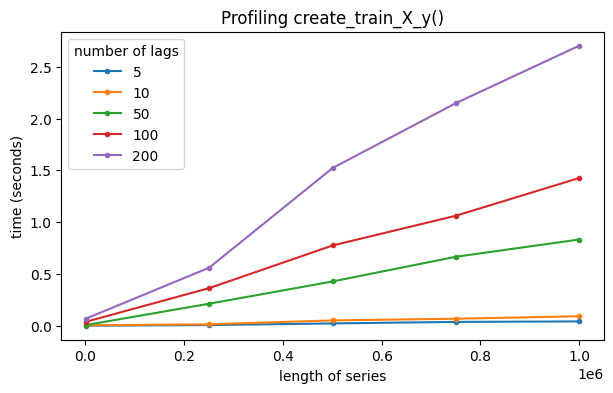

In [7]:
fig, ax = plt.subplots(figsize=(7, 4))
results.plot(ax=ax, marker='.')
ax.set_xlabel('length of series')
ax.set_ylabel('time (seconds)')
ax.set_title('Profiling create_train_X_y()')
ax.legend(title='number of lags');

## Profiling predict

In [8]:
forecaster = ForecasterAutoreg(
                 regressor = DummyRegressor(),
                 lags      = 24
             )

forecaster.fit(y=data)

c:\Users\jaesc2\Miniconda3\envs\skforecast_py11\Lib\site-packages\sklearn\preprocessing\_discretization.py:278: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


In [9]:
%%pyinstrument

_ = forecaster.predict(steps=1000)

_     ._   __/__   _ _  _  _ _/_   Recorded: 18:26:17  Samples:  25
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.193     CPU time: 0.188
/   _/                      v4.6.2

Program: c:\Users\jaesc2\Miniconda3\envs\skforecast_py11\Lib\site-packages\ipykernel_launcher.py --f=c:\Users\jaesc2\AppData\Roaming\jupyter\runtime\kernel-v2-22012TQzJe6tvtQUB.json

0.193 <module>  ..\..\..\AppData\Local\Temp\ipykernel_12608\3639615597.py:1
|- 0.169 [self]  ..\..\..\AppData\Local\Temp\ipykernel_12608\3639615597.py
`- 0.024 ForecasterAutoreg.predict  skforecast\ForecasterAutoreg\ForecasterAutoreg.py:890
   `- 0.024 ForecasterAutoreg._recursive_predict  skforecast\ForecasterAutoreg\ForecasterAutoreg.py:783
      |- 0.008 DummyRegressor.predict  ..\..\..\AppData\Local\Temp\ipykernel_12608\3778797810.py:9
      |  |- 0.006 ones  numpy\core\numeric.py:136
      |  `- 0.002 [self]  ..\..\..\AppData\Local\Temp\ipykernel_12608\3778797810.py
      |- 0.007 [self]  skforecast\ForecasterAutoreg\ForecasterAutoreg.py
      |- 0.004 simplefilter  warnings.py:165
      |  `- 0.004 _add_filter  warnings.py:181
      |     `- 0.003 [self]  warnings.py
      `- 0.003 catch_warnings.__exit__  warnings.py:487
         `- 0.002 [self]  warnings.py

In [10]:
forecaster = ForecasterAutoreg(
                 regressor = HistGradientBoostingRegressor(max_iter=10, random_state=123),
                 lags      = 24
             )

forecaster.fit(y=data)

In [11]:
%%pyinstrument

_ = forecaster.predict(steps=1000)

_     ._   __/__   _ _  _  _ _/_   Recorded: 18:26:17  Samples:  385
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.386     CPU time: 3.078
/   _/                      v4.6.2

Program: c:\Users\jaesc2\Miniconda3\envs\skforecast_py11\Lib\site-packages\ipykernel_launcher.py --f=c:\Users\jaesc2\AppData\Roaming\jupyter\runtime\kernel-v2-22012TQzJe6tvtQUB.json

0.386 <module>  ..\..\..\AppData\Local\Temp\ipykernel_12608\3639615597.py:1
`- 0.386 ForecasterAutoreg.predict  skforecast\ForecasterAutoreg\ForecasterAutoreg.py:890
   `- 0.385 ForecasterAutoreg._recursive_predict  skforecast\ForecasterAutoreg\ForecasterAutoreg.py:783
      |- 0.354 HistGradientBoostingRegressor.predict  sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1737
      |  |- 0.319 HistGradientBoostingRegressor._raw_predict  sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1245
      |  |  |- 0.198 HistGradientBoostingRegressor._predict_iterations  sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1285
      |  |  |  |- 0.119 TreePredictor.predict  sklearn\ensemble\_hist_gradient_boosting\predictor.py:44
      |  |  |  |  `- 0.116 [self]  sklearn\ensemble\_hist_gradient_boosting\predictor.py
      |  |  |  |- 0.064 [self]  sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py
      |  |  |  `- 0.015 _BinMapper.make_known_categories_bitsets  sklearn\ensemble\_hist_gradient_boosting\binning.py:287
      |  |  |     |- 0.007 [self]  sklearn\ensemble\_hist_gradient_boosting\binning.py
      |  |  |     `- 0.005 flatnonzero  numpy\core\numeric.py:615
      |  |  |        `- 0.004 nonzero  numpy\core\fromnumeric.py:1881
      |  |  |- 0.078 HistGradientBoostingRegressor._preprocess_X  sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:243
      |  |  |  `- 0.077 HistGradientBoostingRegressor._validate_data  sklearn\base.py:537
      |  |  |     |- 0.062 check_array  sklearn\utils\validation.py:718
      |  |  |     |  |- 0.016 _num_samples  sklearn\utils\validation.py:364
      |  |  |     |  |  |- 0.008 [self]  sklearn\utils\validation.py
      |  |  |     |  |  `- 0.004 Integral.__instancecheck__  <frozen abc>:117
      |  |  |     |  |- 0.014 [self]  sklearn\utils\validation.py
      |  |  |     |  |- 0.011 simplefilter  warnings.py:165
      |  |  |     |  |  `- 0.009 _add_filter  warnings.py:181
      |  |  |     |  |     `- 0.007 [self]  warnings.py
      |  |  |     |  `- 0.009 _asarray_with_order  sklearn\utils\_array_api.py:501
      |  |  |     |     `- 0.005 _is_numpy_namespace  sklearn\utils\_array_api.py:111
      |  |  |     |- 0.006 [self]  sklearn\base.py
      |  |  |     `- 0.006 HistGradientBoostingRegressor._check_feature_names  sklearn\base.py:448
      |  |  |- 0.025 check_is_fitted  sklearn\utils\validation.py:1548
      |  |  |  `- 0.024 _is_fitted  sklearn\utils\validation.py:1510
      |  |  |     `- 0.023 <listcomp>  sklearn\utils\validation.py:1542
      |  |  |        |- 0.013 [self]  sklearn\utils\validation.py
      |  |  |        `- 0.008 str.endswith  <built-in>
      |  |  |- 0.012 [self]  sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py
      |  |  `- 0.006 getenv  <frozen os>:773
      |  |        [3 frames hidden]  <frozen os>, <frozen _collections_abc>
      |  `- 0.033 check_is_fitted  sklearn\utils\validation.py:1548
      |     `- 0.029 _is_fitted  sklearn\utils\validation.py:1510
      |        `- 0.026 <listcomp>  sklearn\utils\validation.py:1542
      |           |- 0.013 str.endswith  <built-in>
      |           `- 0.012 [self]  sklearn\utils\validation.py
      |- 0.016 [self]  skforecast\ForecasterAutoreg\ForecasterAutoreg.py
      `- 0.010 simplefilter  warnings.py:165
         `- 0.006 _add_filter  warnings.py:181

Inside the `predict` method, the `append` action is the most expensive but, similar to what happen with `fit`, it is negligible compared to the time need by the `predict` method of the regressor.